**In this project we will analyse the sentiment in twitter bassed on people tweet and Many companies use the insights from sentiment analysis to improve customer service and increase brand reputation.**

**we want to install Tweepy because it will access twitter and get details**

In [1]:
pip install Tweepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


**import necessary library for this sentimental analysis**

In [2]:
import tweepy
from textblob import TextBlob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


**In excel stored access keys for twitter**

In [3]:
config=pd.read_excel(r"/kaggle/input/config/config.csv.xlsx")
config

,twitterApiKey,twitterApiSecret,twitterApiAccessToken,twitterApiAccessTokenSecret
0,JVWwfHwPBzLoDc2DfFaFL5gmU,AeMHhW4ORfwU1nb8eWJg4PP7P8kULKOUPn37nrWFeH1E2W...,2943199105-fvKLhg03gbnMPTBAfMyiDWo8fm574aVsnAc...,Iu7NIQYPaXGURY8aeVVozGyV4QQOXZOYOrROp6Ad3641D


In [4]:
twitterApiKey=config['twitterApiKey'][0]
twitterApiSecret=config['twitterApiSecret'][0]
twitterApiAccessToken=config['twitterApiAccessToken'][0]
twitterApiAccessTokenSecret=config['twitterApiAccessTokenSecret'][0]     #use this keys to access the twitter account

**check the authentication**

In [5]:
auth=tweepy.OAuth1UserHandler(twitterApiKey,twitterApiSecret)
auth.set_access_token(twitterApiAccessToken,twitterApiAccessTokenSecret)
twitterApi=tweepy.API(auth,wait_on_rate_limit=True)

**process for retrieving details from twitter for analysis**

In [6]:
def scrape(words, date_since, numtweet):               
 
      
        db = pd.DataFrame(columns=['username',                          #create the columns for the mentioned names
                                   'description',
                                   'location',
                                   'following',
                                   'followers',
                                   'totaltweets',
                                   'retweetcount',
                                   'text',
                                   'hashtags'])
 
        tweets = tweepy.Cursor(twitterApi.search_tweets,                            #use Cursor method to get the required tweet
                               words, lang="en",
                               since_id=date_since,
                               tweet_mode='extended').items(numtweet)
 
 

        list_tweets = [tweet for tweet in tweets]                     #iterate the tweets and stored in list

        i = 1
 
   
        for tweet in list_tweets:                                            #Iterate the list and stored the mentioned column names
                username = tweet.user.screen_name
                description = tweet.user.description 
                location = tweet.user.location
                following = tweet.user.friends_count
                followers = tweet.user.followers_count
                totaltweets = tweet.user.statuses_count
                retweetcount = tweet.retweet_count
                hashtags = tweet.entities['hashtags']
 
    
                try:
                        text = tweet.retweeted_status.full_text                #in case any invalid reference execute the except comment
                except AttributeError:
                        text = tweet.full_text
                hashtext = list()
                for j in range(0, len(hashtags)):
                        hashtext.append(hashtags[j]['text'])
 
    
                ith_tweet = [username, description,
                             location, following,
                             followers, totaltweets,
                             retweetcount, text, hashtext]
                db.loc[len(db)] = ith_tweet
 

             
                i = i+1
        filename = 'tweets_data.csv'               #our collected tweet informations are stored in this file name
 
        db.to_csv(filename)

**pass which details we need from our  our tweet**

In [7]:
words = "pepsi"                           #we get pepsi details so passed pepsi name
date_since = "2023-1-1"
numtweet = 500                              #we  want 500 tweets 
scrape(words, date_since, numtweet)             #call the scrape function

**Read the stored tweet details using pandas library**

In [8]:
Table = pd.read_csv('tweets_data.csv')
Table.head(5)

,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,0,KeySportsTake,Welcome My Take on Everything #1WC #MAGA🇺🇸,"Providence, KY",1760,181,6445,0,Well Good @FordCenter is Switching to Pepsi,[]
1,1,ollarniyan992,European Business University Scholar 20| MScǀU...,Abuja Nigeria,975,203,2202,0,@Rene_noire @Pepsi_Naija @Aquafina May Allah c...,[]
2,2,Blazing9988,artist with no skill still looking for an art ...,Canada,3009,4344,72316,0,@HaleyJean_Tho *sees a can of Pepsi*\n\nPepsi ...,[]
3,3,sashacall,グラブル GENSHIN 🍡🧋 | Do not DM about repost/repr...,NaN,870,75708,122147,0,the way alear walk is so goofy you go funky as...,[]
4,4,StealthAy_,🇮🇪 | Div 2 comp Splatoon | ex comp Fraymakers ...,NaN,735,58,382,0,@origamigoose_ @Heidi__939 I use pepsi sometimes,[]


**Clean the text column so ,no interept doing analyse**

In [9]:
def Clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '',text)
    text = re.sub(r'#', '',text)
    text = re.sub(r'RT[\s]+', '',text)
    text = re.sub(r'https?:\/\/\S+', '',text)
    return text

Table['text'] = Table['text'].apply(Clean_text)

**Remove the empy values ,so not get any confusion during analyse**

In [10]:
Table=Table.drop(Table[Table['text']==''].index)

**For sentimental analyse we use sentiment subjectivity and polarity**

In [11]:
def gettextsubject(txt):
    return TextBlob(txt).sentiment.subjectivity  
def gettextpolarity(txt):
    return TextBlob(txt).sentiment.polarity              #it find the thought based on tweets

**call the funcions**

In [12]:
Table['subjectivity']=Table['text'].apply(gettextsubject)
Table['polarity']=Table['text'].apply(gettextpolarity)

**use function to assighn people reaction column**

In [13]:
def analyse(a):
    if a<0:
        return "NEGATIVE"
    elif a==0:
        return "NEUTRAL"
    else:
        return "POSSITIVE"

Table["Reaction"]=Table['polarity'].apply(analyse)

**calculate the percentage of possitive reaction**

In [14]:
positive=Table[Table['Reaction']=="POSSITIVE"]
print(str(round(positive.shape[0]/(Table.shape[0])*100))+"% of possitve tweets")

42% of possitve tweets


**calculate the percentage of neutral reaction**

In [15]:
Neutral=Table[Table['Reaction']=="NEUTRAL"]
print(str(round(Neutral.shape[0]/(Table.shape[0])*100))+"% of NEUTRAL tweets")

37% of NEUTRAL tweets


**calculate the percentage of negative reaction**

In [16]:
Negative=Table[Table['Reaction']=="NEGATIVE"]
print(str(round(Negative.shape[0]/(Table.shape[0])*100))+"% of possitve tweets")

21% of possitve tweets


**Plot chart for people ecpression using seaborn library**

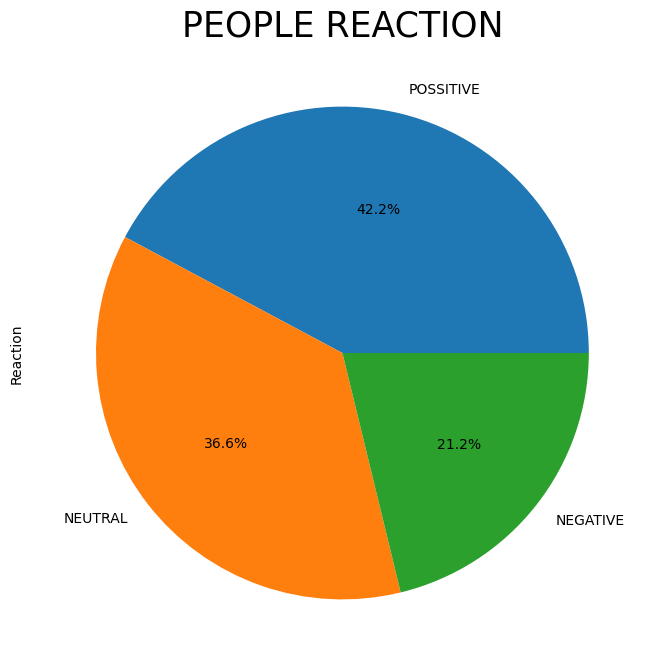

In [17]:
plt.figure(figsize=(8,8))       #chart size
Table['Reaction'].value_counts().plot.pie(autopct="%1.1f%%")    # pie plot with conditions
plt.title('PEOPLE REACTION',fontsize=25)                 #title of this diagram
plt.xlabel('',fontsize=15)
plt.show()

**Total number of influencer people**

In [18]:
Influencer=Table[Table["followers"]>1000]
len(Influencer)

142

**create column influencer are not based on followers count**

In [19]:
def popular(a):
    if a>1000:
        return "Influencer"
    else:
        return "Normal followers"
Table['Popular']=Table["followers"].apply(popular)

**chart for influence people**

[Text(0.5, 1.0, 'INFLUENCER LIST')]

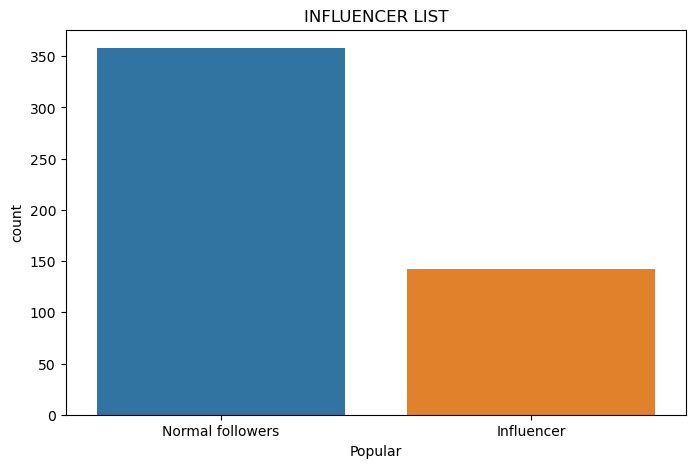

In [20]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x='Popular',data=Table,ax=ax).set(title="INFLUENCER LIST")

**chart for which location people tweet more**

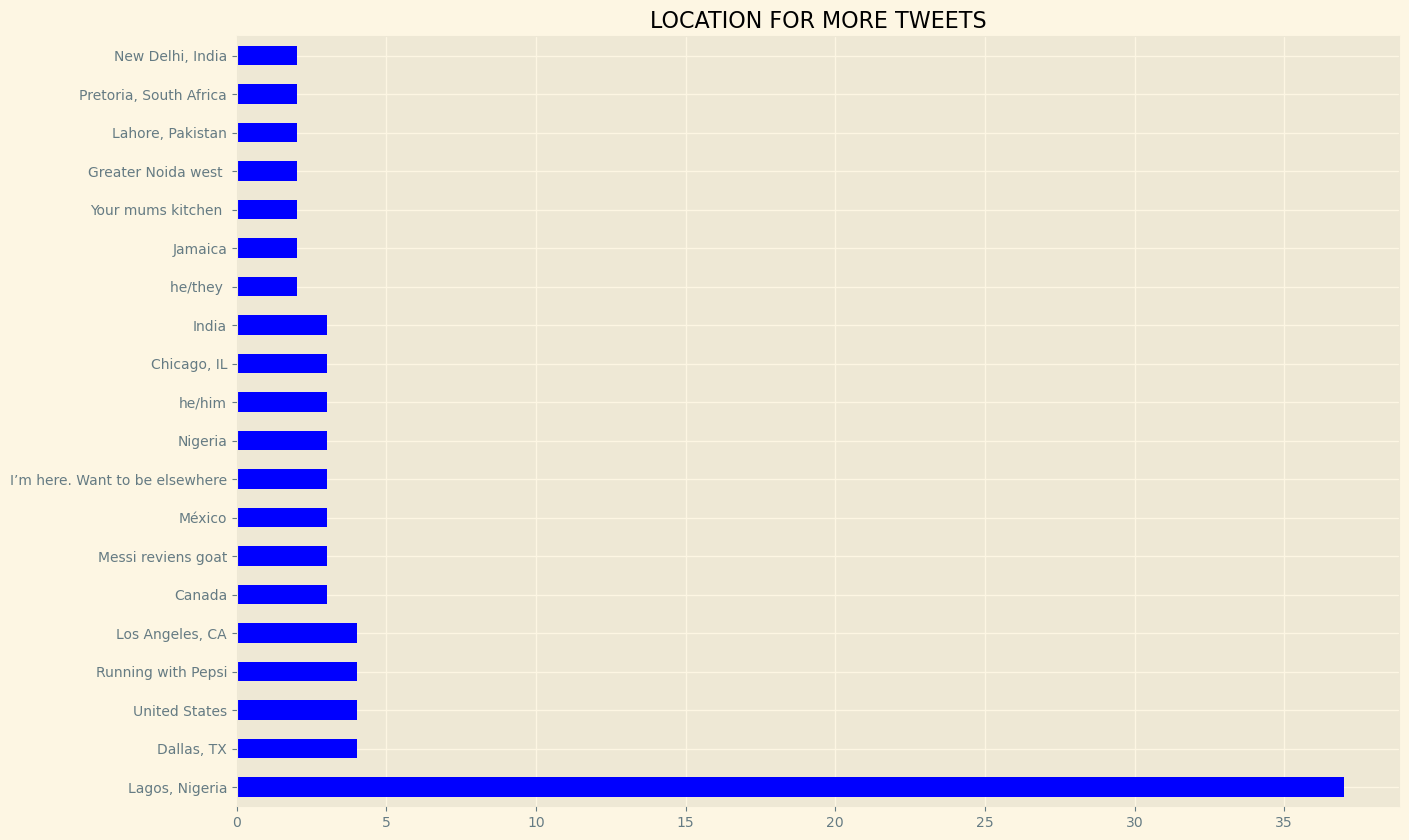

In [21]:
plt.style.use('Solarize_Light2')                                           #choose style format of  this chart
plt.figure(figsize=(15,10))
plt.title("LOCATION FOR MORE TWEETS")                                             
Table["location"].value_counts().head(20).plot(kind="barh",color="b")    
plt.show()

**Find the most viral tweet based on retweet count**

In [22]:
Top = Table.sort_values('retweetcount',ascending=False)
Top1=Top[['text','retweetcount']].head().copy()

**List of top 5 viral tweet**

In [23]:
Top1

,text,retweetcount
28,goodbye to the pepsi logo whose designer was c...,45504
201,goodbye to the pepsi logo whose designer was c...,45504
319,WayV - Phantom (English Ver.) | มีนาคม 2566 | ...,11025
186,WayV - Phantom (English Ver.) | มีนาคม 2566 | ...,11025
190,"Now, I want to introduce you guys to THE Badde...",3923


**SUMMARY**


**Sentiment analysis studies the subjective information in an expression, that is, the opinions, appraisals, emotions, or attitudes towards a topic, person or entity. Expressions can be classified as positive, negative, or neutral.**